In [ ]:
#Setting all the input variables

storm_name = "dorian"
storm_year = 2019
storm_lowerLat= 40

latExtension = 2
lonExtension = 2
dateExtension = 2

focus_variable = "wind_spd_avg"
var_units = "(m s-1)"

#interest_variables = ["wind_spd", "wave_ht", "pressure"]
# Categories: Wind, Surface Waves, Pressure

In [ ]:
# Getting storm data and matching ERDDAP datasets around the storm (time and space)

import tropycal.tracks as tracks
import pandas as pd
from erddapy import ERDDAP
from datetime import timedelta

basin = tracks.TrackDataset(basin='north_atlantic', source='ibtracs')
storm = basin.get_storm((storm_name,storm_year))

# Coordinate selector throws an error when using with Fiona but still generates the graph
storm = storm.sel(lat=[storm_lowerLat,None])

storm_df = storm.to_dataframe()

min_lat = storm_df['lat'].min()
min_lon = storm_df['lon'].min()
max_lat = storm_df['lat'].max()
max_lon = storm_df['lon'].max()
start_date = storm_df.min()['date']
end_date = storm_df.max()['date']

# Get datasets matching time and location criteria, plus a buffer zone

e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv"
)

e.dataset_id = "allDatasets"

e.variables = [
    "datasetID",
    "minLongitude",
    "maxLongitude",
    "minLatitude",
    "maxLatitude",
    "minTime",
    "maxTime"
]

e.constraints = {
    "minTime<=": end_date + timedelta(days = dateExtension),
    "maxTime>=": start_date- timedelta(days = dateExtension),
    "minLatitude>=": min_lat - latExtension,
    "maxLatitude<=": max_lat + latExtension,
    "minLongitude>=": min_lon - lonExtension,
    "maxLongitude<=": max_lon + lonExtension,
}

datasets_df = e.to_pandas(
    parse_dates=True,
).dropna()
datasets = set(datasets_df["datasetID"])

In [ ]:
# Narrow down datasets that contain the focused variable
# Some datasets may not match at certain points if their coverage is inconsistent

matching_datasets = []
for dataset in datasets:
    info_url = e.get_info_url(dataset_id = dataset, response = "csv")
    dataset_info = pd.read_csv(info_url)

    variable_names = set(dataset_info["Variable Name"].unique())
    if focus_variable in variable_names:
         matching_datasets.append(dataset)

print(matching_datasets)

In [ ]:
# Find most recent values for focus var given a time point

selected_time=  start_date + timedelta(days = 1)
matching_points = pd.DataFrame()

e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv",
)

for dataset in matching_datasets:

    e.dataset_id = dataset
    print(dataset)
    
    e.constraints = {
        "time<=": selected_time,
        "time>=": selected_time - timedelta(hours = 6)
    }
        
    e.variables = ["time", "longitude", "latitude", focus_variable]

    try:
        buoy_data= e.to_pandas(
            parse_dates=True,
        ).dropna()
        recent_row = buoy_data.tail(1)
        print(recent_row["time (UTC)"].iloc[0])
        print(recent_row[focus_variable + " " + var_units].iloc[0])
        recent_row.insert(0, "dataset", dataset)
        matching_points = pd.concat([matching_points, recent_row.loc[:]]).reset_index(drop=True)
    except:
        print("couldn't find info for the given dataset for the given time")
    print("-")


                                  dataset            time (UTC)  \
0   sma_negl_cartwright_junction_nlqu0004  2019-09-08T11:52:00Z   
1                          SMA_saint_john  2019-09-08T11:53:01Z   
2                    SMA_port_aux_basques  2019-09-08T11:54:01Z   
3                      SMA_Holyrood_Buoy2  2019-09-08T11:53:00Z   
4                    SMA_Fortune_Bay_Buoy  2019-09-08T11:53:41Z   
5               SMA_port_aux_basqes_wharf  2019-09-08T11:59:15Z   
6                    SMA_red_island_shoal  2019-09-08T11:55:00Z   
7          SMA_saint_john_cruise_terminal  2019-09-08T12:00:00Z   
8                      SMA_holyrood_wharf  2019-09-08T11:51:45Z   
9      sma_negl_north_west_river_nlqu0007  2019-09-08T11:16:00Z   
10                   SMA_saint_john_wharf  2019-09-08T11:59:36Z   
11              sma_negl_red_bay_nlqu0005  2019-09-08T11:52:00Z   
12                            SMA_halifax  2019-09-08T11:53:01Z   
13         sma_negl_black_tickle_nlqu0003  2019-09-08T11:52:00

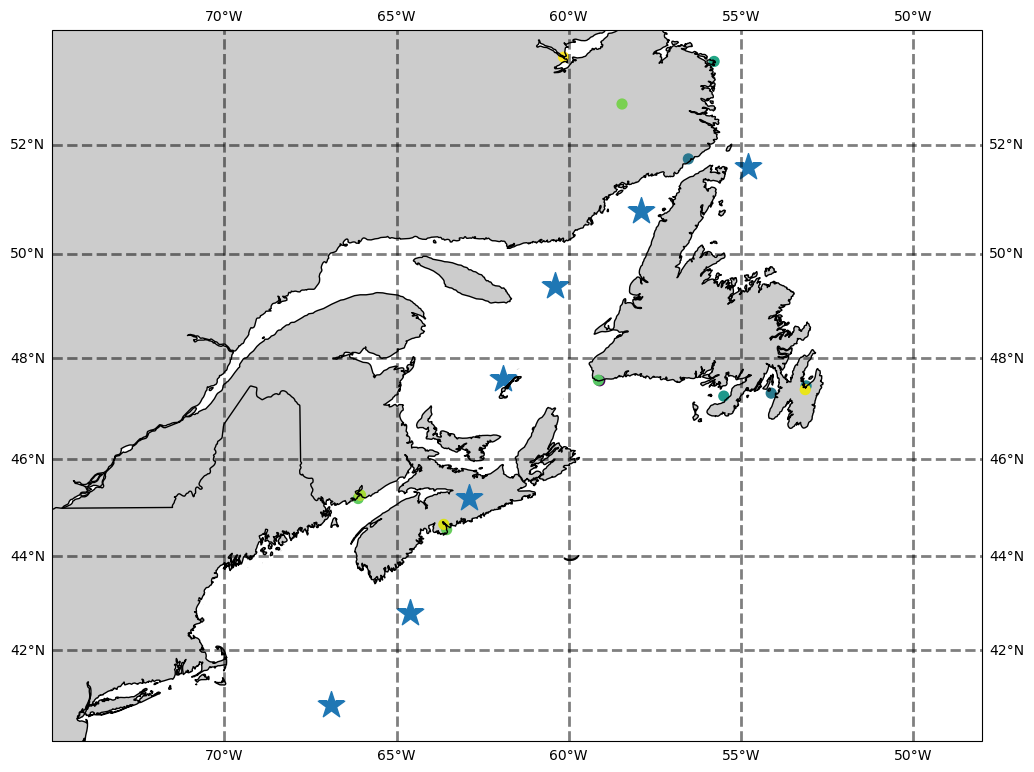

In [79]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
try:
    import cartopy.feature as cfeature
    from cartopy import crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
except:
    warnings.warn("Warning: Cartopy is not installed in your python environment. Plotting functions will not work.")

matching_points.set_index('dataset')
print(matching_points)
                                
proj = ccrs.Mercator(central_longitude=305, min_latitude=40, max_latitude=54)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(12,12))
ax.set_extent([312 , 285, 40, 54], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8')
ax.add_feature(cfeature.BORDERS, zorder=10)
ax.add_feature(cfeature.COASTLINE, zorder=10)
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.scatter(x=matching_points['longitude (degrees_east)'], y=matching_points['latitude (degrees_north)'],  
           c=matching_points['wind_spd_avg (m s-1)'], cmap = 'viridis_r', marker = '.', s=200, transform=ccrs.PlateCarree())

print(storm_df['type'])

# Convert storm to dataframe / dictionary

ax.scatter(x=storm_df['lon'], y=storm_df['lat'], marker = '*', s=400, transform=ccrs.PlateCarree())


In [ ]:
# Create plots  for matching datasets
e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv",
)

for dataset in matching_datasets:

    # Still keeps generating graph after dataset fails for some reason?

    e.dataset_id = dataset

    e.constraints = {
        "time>=": start_date - timedelta(days = 2),
        "time<=": end_date + timedelta(days = 2)
    }

    e.variables = ["time", "longitude", "latitude", focus_variable]

    try:
        buoy_data= e.to_pandas(
            parse_dates=True,
        ).dropna()
        buoy_data.plot(x='time (UTC)', y=focus_variable + ' ' + var_units, title=dataset)
    except:
        print("Data does not exist for %s", dataset) 
